# 초기화 및 환경 설정

In [1]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00


In [3]:
#@title Import, Load and Visualization Code
# Common Implementation: Data Loading and Visualization
import numpy as np
import pandas as pd
import json
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
from matplotlib import rcParams
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv


#나눔고딕설치
!apt-get install -y fonts-nanum
#글꼴 캐시 리프레시
!fc-cache -fv

# NanumGothic 폰트 경로
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# 폰트를 Matplotlib에 강제로 추가
font_manager.fontManager.addfont(font_path)
font_prop = font_manager.FontProperties(fname=font_path)
# Matplotlib에서 폰트 이름으로 설정
rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
plt.rcParams['font.family'] = 'NanumGothic'  # 'Malgun Gothic' 또는 'Noto Sans CJK'로 변경 가능

def interpolate_color(start_color, end_color, factor):
    return tuple(
        int(start + (end - start) * factor) for start, end in zip(start_color, end_color)
    )

def generate_html_table(df, title, recommendations=None, minmax=(0,0),
                        name_column_width_px=150, data_column_width_px=50):
    max_rows = 20
    max_cols = 20

    # 추천 열 너비
    rec_column_width_px = name_column_width_px * 5

    # 열 개수 계산
    num_cols = min(len(df.columns), max_cols)  # 실제 데이터 열 수
    # 테이블 너비 계산: 이름 열 + 데이터 열 + (추천 열 폭 추가 if recommendations 있음)
    table_width_px = name_column_width_px + num_cols * data_column_width_px
    if recommendations is not None:
        table_width_px += rec_column_width_px

    numeric_df = pd.DataFrame(
        [[0 if val == "?" else val for val in row] for row in df.values],
        index=df.index,
        columns=df.columns
    )
    values = numeric_df.values.flatten()
    if minmax == (0,0):
        min_val = np.min(values)
        max_val = np.max(values)
        mid_val = (min_val + max_val) / 2
    else:
        min_val, max_val = minmax

    all_rows = list(df.index)
    if len(all_rows) > max_rows:
        half = max_rows // 2
        rows_to_display = all_rows[:half] + ["..."] + all_rows[-half:]
    else:
        rows_to_display = all_rows

    all_cols = list(df.columns)
    if len(all_cols) > max_cols:
        half = max_cols // 2
        cols_to_display = all_cols[:half] + ["..."] + all_cols[-half:]
    else:
        cols_to_display = all_cols

    # Define colors for gradient
    low_color = (255, 132, 153)  # Light Pink
    mid_color = (255, 250, 205)  # Lemon Chiffon
    high_color = (132, 251, 132)  # Pale Green

    html = []
    html.append(f"<h3>{title}</h3>")
    html.append(f"<table style='border-collapse: collapse; width: {table_width_px}px;'>")  # 동적으로 테이블 폭 설정

    # Header row
    html.append("<tr style='border-bottom: 1px solid #ddd;'>")
    html.append(f"<th style='padding:4px; width:{name_column_width_px}px;'> </th>")
    for col in cols_to_display:
        header = col if col != "..." else "..."
        html.append(f"<th style='padding:4px; text-align:center; width:{data_column_width_px}px;'>{header}</th>")
    if recommendations is not None:
        html.append(f"<th style='padding:4px; text-align:left; width:{rec_column_width_px}px;'>Recommendations</th>")
    html.append("</tr>")

    # Data rows
    for row_name in rows_to_display:
        html.append("<tr>")
        if row_name == "...":
            html.append(f"<td style='padding:4px; text-align:left; font-weight:bold;'>...</td>")
            for _ in cols_to_display:
                html.append(f"<td style='padding:4px; text-align:center;'>...</td>")
            if recommendations is not None:
                html.append("<td style='padding:4px; text-align:left;'>...</td>")
        else:
            html.append(f"<td style='padding:4px; text-align:left; font-weight:bold; width:{name_column_width_px}px;'>{row_name}</td>")
            for col in cols_to_display:
                if col == "...":
                    html.append(f"<td style='padding:4px; text-align:center;'>...</td>")
                else:
                    val = df.at[row_name, col]
                    if val == "?":
                        color = "#FFFFFF"  # placeholder에 대해 흰색
                        display_val = "?"
                    else:
                        val_numeric = numeric_df.at[row_name, col]
                        norm_value = (val_numeric - min_val) / (max_val - min_val) if max_val > min_val else 0.5
                        if norm_value <= 0.5:
                            factor = norm_value * 2  # 낮은 범위로 스케일
                            color = interpolate_color(low_color, mid_color, factor)
                        else:
                            factor = (norm_value - 0.5) * 2  # 높은 범위로 스케일
                            color = interpolate_color(mid_color, high_color, factor)
                        color = f"rgb({color[0]}, {color[1]}, {color[2]})"
                        display_val = f"{val_numeric:.2f}"
                    html.append(f"<td style='padding:4px; text-align:center; background-color:{color}; width:{data_column_width_px}px;'>{display_val}</td>")
            if recommendations is not None:
                rec_items = recommendations.get(row_name, [])
                rec_text = ", ".join([f"{item} ({score:.2f})" for item, score in rec_items])
                html.append(f"<td style='padding:4px; text-align:left; width:{rec_column_width_px}px;'>{rec_text}</td>")
        html.append("</tr>")

    html.append("</table>")
    display(HTML(''.join(html)))









def display_ratings_with_placeholders(ratings, user_names, item_names):
    df = pd.DataFrame(ratings, index=user_names, columns=item_names)
    df_with_placeholders = pd.DataFrame(
        [["?" if val == 0 else val for val in row] for row in df.values],
        index=df.index,
        columns=df.columns
    )
    generate_html_table(df_with_placeholders, "Ratings with Placeholders (? for 0)")






def load_data_and_make_matrices(ratings_json_path, movies_xlsx_path):
    """
    Load rating and movie data, and process it into matrices.
    Args:
        ratings_json_path (str): Path to the JSON file containing ratings.
        movies_xlsx_path (str): Path to the Excel file containing movie metadata.

    Returns:
        tuple: rating_matrix, item_features, user_names, item_names
    """
    import pandas as pd
    import numpy as np
    import json

    # Load movie metadata
    df_movies = pd.read_excel(movies_xlsx_path)
    item_names = df_movies["제목"].tolist()
    genres = ["액션", "어드벤처", "SF", "드라마", "스릴러", "코미디", "판타지", "공포"]

    # Convert genre columns to binary features with DataFrame.map
    item_features = df_movies[genres].fillna("").astype(str).apply(
        lambda col: col.map(lambda x: 1 if x.strip().upper() == "O" else 0)
    ).to_numpy(dtype=int)

    # Load user ratings
    with open(ratings_json_path, "r", encoding="utf-8") as f:
        user_data = json.load(f)

    user_names = [user["user"] for user in user_data]
    rating_matrix = np.zeros((len(user_data), len(item_names)))

    # Map movie ratings into the matrix
    item_index_map = {name: idx for idx, name in enumerate(item_names)}
    for user_idx, user in enumerate(user_data):
        for movie, score in user["ratings"].items():
            if movie in item_index_map:
                rating_matrix[user_idx, item_index_map[movie]] = score

    return rating_matrix, item_features, user_names, item_names





def generate_summary_table(recommendations_list, system_names_list, user_names):

    # 추천 결과를 하나의 데이터프레임으로 결합
    combined_recommendations_df = pd.DataFrame(index=user_names)

    # 추천 시스템 리스트를 동적으로 처리하여 테이블에 열 추가
    for idx, recommendation in enumerate(recommendations_list):
        system_name = system_names_list[idx]  # 각 추천 시스템의 이름
        combined_recommendations_df[system_name] = [
            ", ".join([f"{item} ({score:.2f})" for item, score in recommendation.get(user, [])])
            for user in user_names
        ]

    return combined_recommendations_df




def transform_binary_to_signed(array):

    # Replace all 0s with -1s
    transformed_array = np.where(array == 0, -1, array)
    return transformed_array



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (12.6 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124565 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

등록된 폰트 이름: NanumGothic


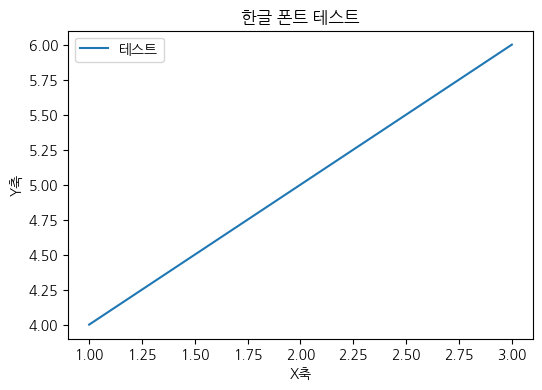

In [4]:


# 폰트 확인
print("등록된 폰트 이름:", font_prop.get_name())

# 한글 테스트
plt.figure(figsize=(6, 4))
plt.plot([1, 2, 3], [4, 5, 6], label='테스트')
plt.title('한글 폰트 테스트')
plt.xlabel('X축')
plt.ylabel('Y축')
plt.legend()
plt.show()


# 하이브리드 추천 알고리즘

In [5]:
#@title hybrid system code

def hybrid_recommendations(ratings, item_features, user_names=None, item_names=None, alpha=0.5, top_n=1, display_html=True, similarity_method="default"):
    """
    Recommendation System Function with optional similarity calculations.

    Parameters:
        ratings (numpy.ndarray): User-Item rating matrix.
        item_features (numpy.ndarray): Item feature matrix.
        user_names (list of str, optional): Names of users.
        item_names (list of str, optional): Names of items.
        alpha (float): Weight for hybrid recommendation (0 to 1).
        top_n (int): Number of top recommendations per user.
        display_html (bool): HTML 출력 여부. 기본값 True.
        similarity_method (str): Method for similarity calculation ("default", "common", "jaccard").

    Returns:
        dict: {
            "User-Based": 사용자 기반 추천 결과,
            "Item-Based": 아이템 기반 추천 결과,
            "Hybrid": 하이브리드 추천 결과
        }
    """
    import numpy as np
    import pandas as pd
    from sklearn.metrics.pairwise import cosine_similarity

    num_users, num_items = ratings.shape

    # Ensure user_names and item_names are properly set
    if user_names is None:
        user_names = [f"User {i+1}" for i in range(num_users)]
    if item_names is None:
        item_names = [f"Item {i+1}" for i in range(num_items)]

    def default_cosine_similarity(matrix):
        """
        Computes default cosine similarity by treating 0 as 3 and subtracting 3 from other values.
        """
        adjusted_matrix = np.where(matrix > 0, matrix - 3, 0)  # Adjust values
        return cosine_similarity(adjusted_matrix)

    def common_item_cosine_similarity(matrix):
        """
        Computes cosine similarity using only common rated items, subtracting 3.
        """
        num_users = matrix.shape[0]
        similarity = np.zeros((num_users, num_users))
        for i in range(num_users):
            for j in range(num_users):
                mask = (matrix[i] > 0) & (matrix[j] > 0)
                if np.sum(mask) > 0:
                    vec_i = matrix[i, mask] - 3
                    vec_j = matrix[j, mask] - 3
                    numerator = np.dot(vec_i, vec_j)
                    denominator = np.sqrt(np.dot(vec_i, vec_i)) * np.sqrt(np.dot(vec_j, vec_j))
                    similarity[i, j] = numerator / denominator if denominator != 0 else 0
        return similarity

    def jaccard_weighted_cosine_similarity(matrix):
        """
        Computes Jaccard-weighted cosine similarity.
        """
        num_users = matrix.shape[0]
        similarity = np.zeros((num_users, num_users))
        for i in range(num_users):
            for j in range(num_users):
                mask = (matrix[i] > 0) & (matrix[j] > 0)
                if np.sum(mask) > 0:
                    vec_i = matrix[i, mask] - 3
                    vec_j = matrix[j, mask] - 3
                    numerator = np.dot(vec_i, vec_j)
                    denominator = np.sqrt(np.dot(vec_i, vec_i)) * np.sqrt(np.dot(vec_j, vec_j))
                    jaccard_index = np.sum(mask) / ((matrix[i] > 0).sum() + (matrix[j] > 0).sum() - np.sum(mask))
                    similarity[i, j] = (numerator / denominator) * jaccard_index if denominator != 0 else 0
        return similarity

    # Select similarity method
    if similarity_method == "default":
        user_similarity = default_cosine_similarity(ratings)
        item_similarity = cosine_similarity(item_features)
    elif similarity_method == "common":
        user_similarity = common_item_cosine_similarity(ratings)
        item_similarity = cosine_similarity(item_features)
    elif similarity_method == "jaccard":
        user_similarity = jaccard_weighted_cosine_similarity(ratings)
        item_similarity = cosine_similarity(item_features)
    else:
        raise ValueError("Invalid similarity_method. Choose from 'default', 'common', or 'jaccard'.")

    user_similarity_df = pd.DataFrame(user_similarity, index=user_names, columns=user_names)
    item_similarity_df = pd.DataFrame(item_similarity, index=item_names, columns=item_names)

    # 2) 예측 평점 계산
    user_based_prediction = user_similarity.dot(ratings) / np.array([np.abs(user_similarity).sum(axis=1)]).T
    item_based_prediction = ratings.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])

    hybrid_prediction = alpha * user_based_prediction + (1 - alpha) * item_based_prediction

    user_based_prediction_df = pd.DataFrame(user_based_prediction, index=user_names, columns=item_names)
    item_based_prediction_df = pd.DataFrame(item_based_prediction, index=user_names, columns=item_names)
    hybrid_prediction_df = pd.DataFrame(hybrid_prediction, index=user_names, columns=item_names)

    # 3) 추천 아이템 선정 함수
    def recommend_items(prediction_df, ratings, top_n):
        recommendations = {}
        for user_idx, user_name in enumerate(prediction_df.index):
            user_ratings = ratings[user_idx]
            user_predictions = prediction_df.iloc[user_idx]
            unseen_items = [
                (item_names[item_idx], score)
                for item_idx, score in enumerate(user_predictions)
                if user_ratings[item_idx] == 0
            ]
            if unseen_items:
                top_items = sorted(unseen_items, key=lambda x: x[1], reverse=True)[:top_n]
            else:
                top_items = [(item_names[item_idx], score) for item_idx, score in enumerate(user_predictions) if score == max(user_predictions)]
            recommendations[user_name] = top_items
        return recommendations

    user_based_recommendations = recommend_items(user_based_prediction_df, ratings, top_n)
    item_based_recommendations = recommend_items(item_based_prediction_df, ratings, top_n)
    hybrid_recommendations = recommend_items(hybrid_prediction_df, ratings, top_n)

    # 4) 최종 출력 (HTML 출력 여부에 따라)
    if display_html:
        generate_html_table(user_similarity_df, "User Similarity (사용자 간 유사도)", minmax=(-1,1))
        generate_html_table(item_similarity_df, "Item Similarity (아이템 간 유사도)", minmax=(-1,1))
        generate_html_table(user_based_prediction_df, "User-Based Prediction (사용자 기반 예측)", user_based_recommendations)
        generate_html_table(item_based_prediction_df, "Item-Based Prediction (아이템 기반 예측)", item_based_recommendations)
        generate_html_table(hybrid_prediction_df, "Hybrid Prediction (하이브리드 예측)", hybrid_recommendations)

    return [hybrid_prediction_df, hybrid_recommendations]


In [6]:
# Example Execution: Hybrid Algorithm
ratings_example = np.array([
    [5, 4, 0, 1, 0, 0],
    [4, 0, 0, 2, 3, 0],
    [1, 1, 0, 5, 0, 4],
    [0, 0, 5, 4, 0, 0],
])

item_features_example = np.array([
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 0],
    [0, 0, 1],
    [1, 0, 0],
    [0, 1, 0],
])

# Hybrid recommendation function
hybrid_recommendations_result = hybrid_recommendations(
    ratings=ratings_example,
    item_features=transform_binary_to_signed(item_features_example),
    alpha=0.5,
    top_n=2,
    similarity_method="jaccard"
)

,User 1,User 2,User 3,User 4
User 1,1.00,0.50,-0.72,-0.25
User 2,0.50,1.00,-0.40,-0.25
User 3,-0.72,-0.40,1.00,0.20
User 4,-0.25,-0.25,0.20,1.00


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
Item 1,1.00,-0.33,-0.33,0.33,0.33,-1.00
Item 2,-0.33,1.00,-0.33,0.33,-1.00,0.33
Item 3,-0.33,-0.33,1.00,-1.00,0.33,0.33
Item 4,0.33,0.33,-1.00,1.00,-0.33,-0.33
Item 5,0.33,-1.00,0.33,-0.33,1.00,-0.33
Item 6,-1.00,0.33,0.33,-0.33,-0.33,1.00


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Recommendations
User 1,2.54,1.33,-0.51,-1.06,0.61,-1.17,"Item 5 (0.61), Item 3 (-0.51)"
User 2,2.84,0.74,-0.58,-0.23,1.40,-0.74,"Item 2 (0.74), Item 3 (-0.58)"
User 3,-1.81,-0.81,0.43,1.84,-0.52,1.72,"Item 3 (0.43), Item 5 (-0.52)"
User 4,-1.21,-0.47,2.94,2.50,-0.44,0.47,"Item 6 (0.47), Item 5 (-0.44)"


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Recommendations
User 1,1.20,0.80,-1.20,1.20,-0.80,-1.20,"Item 5 (-0.80), Item 6 (-1.20)"
User 2,1.70,-1.10,-0.70,0.70,1.10,-1.70,"Item 3 (-0.70), Item 2 (-1.10)"
User 3,-0.50,1.10,-1.30,1.30,-1.10,0.50,"Item 5 (-1.10), Item 3 (-1.30)"
User 4,-0.10,-0.10,0.30,-0.30,0.10,0.10,"Item 6 (0.10), Item 5 (0.10)"


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Recommendations
User 1,1.87,1.06,-0.85,0.07,-0.10,-1.18,"Item 5 (-0.10), Item 3 (-0.85)"
User 2,2.27,-0.18,-0.64,0.23,1.25,-1.22,"Item 2 (-0.18), Item 3 (-0.64)"
User 3,-1.16,0.14,-0.43,1.57,-0.81,1.11,"Item 3 (-0.43), Item 5 (-0.81)"
User 4,-0.65,-0.29,1.62,1.10,-0.17,0.29,"Item 6 (0.29), Item 5 (-0.17)"


In [7]:
# Load real data
rating_matrix, item_features, user_names, item_names = load_data_and_make_matrices(
    ratings_json_path="/content/drive/MyDrive/Source/ratings.json",
    movies_xlsx_path="/content/drive/MyDrive/Source/movies.xlsx"
)

# Run hybrid recommendation
hybrid_recommendation_results = hybrid_recommendations(
    ratings=rating_matrix,
    item_features=transform_binary_to_signed(item_features),
    user_names=user_names,
    item_names=item_names,
    alpha=0.5,
    top_n=2,
    display_html=True,
    similarity_method="default"
)

,Amy,Ethan,고얭이,ROY,어,ben,roxie,Leo,jack,hanskim,null,Rio,henry,Alex Oh,김민경,Sophie Kang,Jen,ella.yang
Amy,1.00,0.31,0.00,-0.09,0.04,-0.06,0.18,0.18,0.12,0.32,0.07,-0.00,0.20,0.23,-0.11,0.29,0.10,0.12
Ethan,0.31,1.00,0.34,-0.03,0.20,0.25,0.15,0.31,0.10,0.38,0.06,0.34,0.06,0.17,0.13,0.26,0.25,0.31
고얭이,0.00,0.34,1.00,-0.14,0.19,0.31,0.14,0.00,0.00,0.28,0.00,0.19,0.22,0.19,0.18,0.00,0.00,0.00
ROY,-0.09,-0.03,-0.14,1.00,-0.29,-0.26,-0.14,-0.21,0.07,-0.30,0.21,-0.34,-0.27,-0.38,-0.35,-0.17,-0.36,-0.07
어,0.04,0.20,0.19,-0.29,1.00,0.83,0.39,0.21,0.28,0.28,0.00,0.33,0.34,0.45,0.40,0.26,0.51,0.00
ben,-0.06,0.25,0.31,-0.26,0.83,1.00,0.38,0.18,0.35,0.43,0.14,0.50,0.48,0.53,0.55,0.32,0.43,0.12
roxie,0.18,0.15,0.14,-0.14,0.39,0.38,1.00,0.33,0.44,0.27,0.13,0.22,0.39,0.28,0.14,0.54,0.18,0.00
Leo,0.18,0.31,0.00,-0.21,0.21,0.18,0.33,1.00,0.00,0.32,0.00,0.44,0.20,0.21,0.00,0.41,0.53,0.00
jack,0.12,0.10,0.00,0.07,0.28,0.35,0.44,0.00,1.00,0.22,0.27,0.15,0.13,0.21,0.28,0.41,0.00,0.00
hanskim,0.32,0.38,0.28,-0.30,0.28,0.43,0.27,0.32,0.22,1.00,0.07,0.32,0.36,0.52,0.34,0.23,0.35,0.11


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드
인셉션,1.00,-0.00,0.00,0.50,0.25,-0.00,-0.00,0.25,0.25,0.75,...,-0.50,0.25,0.50,-0.00,0.25,-0.25,-0.00,0.25,0.50,-0.25
소셜 네트워크,-0.00,1.00,0.50,0.50,-0.25,0.50,0.50,-0.25,0.75,-0.25,...,-0.00,0.75,-0.00,1.00,0.25,0.75,0.00,-0.25,0.50,0.25
블랙 스완,0.00,0.50,1.00,0.50,-0.75,0.00,-0.00,-0.75,0.75,-0.25,...,-0.50,0.75,0.00,0.50,-0.25,0.25,-0.50,-0.75,0.50,-0.25
드라이브,0.50,0.50,0.50,1.00,-0.25,0.50,-0.00,-0.25,0.75,0.25,...,-0.50,0.75,0.50,0.50,0.25,0.25,-0.00,-0.25,1.00,-0.25
어벤져스,0.25,-0.25,-0.75,-0.25,1.00,-0.25,0.25,0.50,-0.50,0.50,...,0.25,-0.50,0.25,-0.25,0.50,-0.50,0.75,0.50,-0.25,-0.00
장고: 분노의 추적자,-0.00,0.50,0.00,0.50,-0.25,1.00,-0.00,0.25,0.25,-0.25,...,0.00,0.25,-0.00,0.50,0.25,0.75,-0.00,0.25,0.50,0.25
인터스텔라,-0.00,0.50,-0.00,-0.00,0.25,-0.00,1.00,0.25,0.25,0.25,...,-0.00,0.25,-0.00,0.50,0.75,0.25,0.00,0.25,-0.00,-0.25
가디언즈 오브 갤럭시,0.25,-0.25,-0.75,-0.25,0.50,0.25,0.25,1.00,-0.50,0.50,...,0.25,-0.50,0.25,-0.25,0.50,-0.00,0.25,1.00,-0.25,-0.00
위플래쉬,0.25,0.75,0.75,0.75,-0.50,0.25,0.25,-0.50,1.00,-0.00,...,-0.25,1.00,0.25,0.75,-0.00,0.50,-0.25,-0.50,0.75,0.00
매드 맥스: 분노의 도로,0.75,-0.25,-0.25,0.25,0.50,-0.25,0.25,0.50,-0.00,1.00,...,-0.25,-0.00,0.75,-0.25,0.50,-0.50,0.25,0.50,0.25,-0.50


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,3.73,2.23,1.38,0.29,1.91,0.48,2.69,1.10,1.28,1.04,...,0.02,1.66,0.79,-0.03,1.72,0.00,0.57,0.40,1.17,1.27,"어벤져스 (1.91), 블랙 스완 (1.38)"
Ethan,3.87,1.30,0.86,0.36,2.86,1.25,2.49,2.59,0.97,2.40,...,0.03,1.15,0.73,-0.01,1.34,0.00,1.09,0.23,2.41,0.46,"탑건: 매버릭 (1.69), 겟 아웃 (1.32)"
고얭이,2.67,1.71,0.99,1.60,1.97,0.83,1.79,3.86,1.11,3.68,...,0.00,1.21,2.34,-0.04,1.70,0.00,0.82,0.07,2.24,0.59,"인셉션 (2.67), 기생충 (2.40)"
ROY,-2.61,-1.57,-0.81,-0.41,-1.05,0.23,-0.61,-1.62,-0.47,-0.83,...,0.18,-0.84,-0.69,0.21,-1.37,0.00,-0.48,-0.20,-1.85,-0.53,"셰이프 오브 워터 (0.00), 이니셰린의 밴시 (0.00)"
어,3.56,2.14,1.09,0.41,2.00,0.44,2.24,2.85,2.02,1.90,...,0.02,1.90,1.02,-0.05,1.96,0.00,0.63,0.23,3.04,0.60,"인터스텔라 (2.24), 라라랜드 (2.09)"
ben,3.36,2.00,1.14,0.51,2.31,0.62,2.42,2.78,1.71,2.20,...,0.02,1.68,1.08,-0.04,1.93,0.00,0.71,0.25,2.82,0.65,"겟 아웃 (1.30), 블랙 스완 (1.14)"
roxie,3.74,1.60,1.99,0.48,1.91,0.52,3.16,2.34,1.90,1.45,...,0.16,2.12,1.64,-0.03,1.43,0.00,0.51,0.48,2.21,0.61,"기생충 (2.12), 어벤져스 (1.91)"
Leo,4.33,1.32,1.28,0.22,2.16,0.75,1.97,1.84,0.96,1.07,...,0.03,1.27,0.72,-0.05,1.09,0.00,0.78,0.40,2.14,0.33,"기생충 (2.40), 어벤져스 (2.16)"
jack,2.77,1.45,1.47,0.17,1.94,0.48,3.89,1.82,1.69,1.57,...,0.13,1.67,0.94,0.02,1.47,0.00,0.48,0.44,1.98,0.65,"인셉션 (2.77), 기생충 (2.11)"
hanskim,3.61,2.22,1.47,0.48,2.40,0.55,2.12,2.10,1.15,2.35,...,-0.01,1.22,1.04,-0.05,2.03,0.00,0.75,0.21,2.35,0.73,"인터스텔라 (2.12), 가디언즈 오브 갤럭시 (2.10)"


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,1.37,1.21,0.78,1.16,-0.40,0.86,1.22,0.05,1.22,0.65,...,-0.73,1.22,0.93,1.21,0.69,0.94,-0.62,0.05,1.16,-0.14,"엑스 마키나 (1.49), 블레이드 러너 2049 (1.49)"
Ethan,1.78,0.67,-0.45,0.97,0.85,1.04,1.49,1.31,0.48,1.48,...,-0.39,0.48,1.65,0.67,1.71,0.35,0.78,1.31,0.97,-0.43,"듄 (1.71), 미션 임파서블: 데드 레코닝 파트 원 (1.65)"
고얭이,0.49,0.26,-0.10,0.45,0.13,0.55,0.31,0.42,0.26,0.46,...,0.10,0.26,0.86,0.26,0.42,0.26,0.38,0.42,0.45,0.02,"탑건: 매버릭 (0.56), 장고: 분노의 추적자 (0.55)"
ROY,1.22,1.10,0.52,1.28,-0.01,0.90,1.31,0.15,1.10,0.84,...,-0.57,1.10,1.40,1.10,1.07,0.69,0.13,0.15,1.28,-0.39,"드라이브 (1.28), 탑건: 매버릭 (1.19)"
어,1.22,1.29,0.87,1.62,-0.42,1.31,1.06,-0.17,1.36,0.60,...,-0.90,1.36,1.30,1.29,0.92,0.95,-0.22,-0.17,1.62,-0.41,"드라이브 (1.62), 1917 (1.62)"
ben,1.78,1.52,0.65,1.84,0.01,1.49,1.86,0.36,1.47,1.19,...,-1.00,1.47,1.84,1.52,1.68,1.00,0.11,0.36,1.84,-0.67,"드라이브 (1.84), 1917 (1.84)"
roxie,1.31,1.25,1.06,1.75,-0.40,1.00,0.96,-0.36,1.44,0.81,...,-1.00,1.44,1.84,1.25,0.86,0.69,0.02,-0.36,1.75,-0.67,"드라이브 (1.75), 레버넌트: 죽음에서 돌아온 자 (1.71)"
Leo,0.31,-0.00,0.00,0.12,0.06,-0.00,-0.00,0.07,0.05,0.19,...,-0.16,0.05,0.19,-0.00,0.07,-0.06,-0.00,0.07,0.12,-0.08,"테넷 (0.31), 매드 맥스: 분노의 도로 (0.19)"
jack,0.20,0.41,0.03,0.29,0.22,0.29,0.98,0.25,0.23,0.33,...,-0.20,0.23,0.33,0.41,0.83,0.20,0.18,0.25,0.29,-0.43,"블랙 팬서 (0.83), 아바타: 물의 길 (0.83)"
hanskim,1.35,1.11,0.25,1.29,0.18,1.33,1.37,0.54,0.94,0.89,...,-0.59,0.94,1.33,1.11,1.36,0.80,0.29,0.54,1.29,-0.33,"인터스텔라 (1.37), 블랙 팬서 (1.36)"


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,2.55,1.72,1.08,0.72,0.76,0.67,1.96,0.57,1.25,0.85,...,-0.36,1.44,0.86,0.59,1.21,0.47,-0.03,0.23,1.17,0.56,"블랙 스완 (1.08), 1917 (1.05)"
Ethan,2.83,0.99,0.21,0.67,1.86,1.14,1.99,1.95,0.72,1.94,...,-0.18,0.82,1.19,0.33,1.53,0.18,0.93,0.77,1.69,0.02,"탑건: 매버릭 (1.52), 듄 (1.28)"
고얭이,1.58,0.98,0.44,1.03,1.05,0.69,1.05,2.14,0.68,2.07,...,0.05,0.74,1.60,0.11,1.06,0.13,0.60,0.25,1.35,0.30,"인셉션 (1.58), 범죄도시 (1.35)"
ROY,-0.70,-0.23,-0.15,0.43,-0.53,0.56,0.35,-0.73,0.31,0.01,...,-0.19,0.13,0.35,0.65,-0.15,0.35,-0.17,-0.03,-0.29,-0.46,"드라이브 (0.43), 노매드랜드 (0.40)"
어,2.39,1.71,0.98,1.02,0.79,0.87,1.65,1.34,1.69,1.25,...,-0.44,1.63,1.16,0.62,1.44,0.48,0.20,0.03,2.33,0.09,"인터스텔라 (1.65), 라라랜드 (1.52)"
ben,2.57,1.76,0.90,1.17,1.16,1.05,2.14,1.57,1.59,1.69,...,-0.49,1.58,1.46,0.74,1.80,0.50,0.41,0.30,2.33,-0.01,"미션 임파서블: 데드 레코닝 파트 원 (1.46), 1917 (1.32)"
roxie,2.53,1.42,1.52,1.12,0.75,0.76,2.06,0.99,1.67,1.13,...,-0.42,1.78,1.74,0.61,1.15,0.35,0.27,0.06,1.98,-0.03,"기생충 (1.57), 컨택트 (1.44)"
Leo,2.32,0.66,0.64,0.17,1.11,0.37,0.98,0.95,0.51,0.63,...,-0.07,0.66,0.46,-0.02,0.58,-0.03,0.39,0.24,1.13,0.13,"기생충 (1.20), 범죄도시 (1.13)"
jack,1.48,0.93,0.75,0.23,1.08,0.39,2.44,1.04,0.96,0.95,...,-0.04,0.95,0.63,0.21,1.15,0.10,0.33,0.35,1.13,0.11,"인셉션 (1.48), 아바타: 물의 길 (1.15)"
hanskim,2.48,1.66,0.86,0.88,1.29,0.94,1.75,1.32,1.04,1.62,...,-0.30,1.08,1.18,0.53,1.69,0.40,0.52,0.38,1.82,0.20,"인터스텔라 (1.75), 블랙 팬서 (1.48)"


In [ ]:

# Common
hybrid_recommendation_results = hybrid_recommendations(
    ratings=rating_matrix,
    item_features=transform_binary_to_signed(item_features),
    user_names=user_names,
    item_names=item_names,
    alpha=0.5,
    top_n=2,
    display_html=True,
    similarity_method="common"
)


,Amy,Ethan,고얭이,ROY,어,ben,roxie,Leo,jack,hanskim,null,Rio,henry,Alex Oh,김민경,Sophie Kang,Jen,ella.yang
Amy,1.00,0.54,0.00,-0.15,0.07,-0.10,0.49,1.00,0.67,0.50,0.58,0.00,0.31,0.46,-0.20,0.91,0.18,0.89
Ethan,0.54,1.00,0.80,-0.04,0.43,0.34,0.43,1.00,0.71,0.54,0.15,0.48,0.09,0.30,0.27,0.74,0.58,0.67
고얭이,0.00,0.80,1.00,-0.42,1.00,0.82,0.71,0.00,0.00,0.94,0.00,0.71,0.50,0.58,0.89,0.00,0.00,0.00
ROY,-0.15,-0.04,-0.42,1.00,-0.59,-0.41,-0.23,-1.00,0.45,-0.59,0.57,-0.53,-0.33,-0.60,-0.67,-0.46,-0.84,-0.19
어,0.07,0.43,1.00,-0.59,1.00,1.00,0.61,1.00,1.00,0.62,0.00,0.74,0.68,0.80,0.95,0.76,0.94,0.00
ben,-0.10,0.34,0.82,-0.41,1.00,1.00,0.63,1.00,0.95,0.67,0.47,0.81,0.73,0.70,0.81,0.80,0.88,0.71
roxie,0.49,0.43,0.71,-0.23,0.61,0.63,1.00,1.00,1.00,0.94,0.71,0.58,0.86,0.60,0.50,0.93,0.67,0.00
Leo,1.00,1.00,0.00,-1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00
jack,0.67,0.71,0.00,0.45,1.00,0.95,1.00,0.00,1.00,0.80,1.00,1.00,0.58,0.95,0.71,0.95,0.00,0.00
hanskim,0.50,0.54,0.94,-0.59,0.62,0.67,0.94,1.00,0.80,1.00,0.41,0.86,0.65,0.85,0.78,1.00,0.77,0.45


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드
인셉션,1.00,-0.00,0.00,0.50,0.25,-0.00,-0.00,0.25,0.25,0.75,...,-0.50,0.25,0.50,-0.00,0.25,-0.25,-0.00,0.25,0.50,-0.25
소셜 네트워크,-0.00,1.00,0.50,0.50,-0.25,0.50,0.50,-0.25,0.75,-0.25,...,-0.00,0.75,-0.00,1.00,0.25,0.75,0.00,-0.25,0.50,0.25
블랙 스완,0.00,0.50,1.00,0.50,-0.75,0.00,-0.00,-0.75,0.75,-0.25,...,-0.50,0.75,0.00,0.50,-0.25,0.25,-0.50,-0.75,0.50,-0.25
드라이브,0.50,0.50,0.50,1.00,-0.25,0.50,-0.00,-0.25,0.75,0.25,...,-0.50,0.75,0.50,0.50,0.25,0.25,-0.00,-0.25,1.00,-0.25
어벤져스,0.25,-0.25,-0.75,-0.25,1.00,-0.25,0.25,0.50,-0.50,0.50,...,0.25,-0.50,0.25,-0.25,0.50,-0.50,0.75,0.50,-0.25,-0.00
장고: 분노의 추적자,-0.00,0.50,0.00,0.50,-0.25,1.00,-0.00,0.25,0.25,-0.25,...,0.00,0.25,-0.00,0.50,0.25,0.75,-0.00,0.25,0.50,0.25
인터스텔라,-0.00,0.50,-0.00,-0.00,0.25,-0.00,1.00,0.25,0.25,0.25,...,-0.00,0.25,-0.00,0.50,0.75,0.25,0.00,0.25,-0.00,-0.25
가디언즈 오브 갤럭시,0.25,-0.25,-0.75,-0.25,0.50,0.25,0.25,1.00,-0.50,0.50,...,0.25,-0.50,0.25,-0.25,0.50,-0.00,0.25,1.00,-0.25,-0.00
위플래쉬,0.25,0.75,0.75,0.75,-0.50,0.25,0.25,-0.50,1.00,-0.00,...,-0.25,1.00,0.25,0.75,-0.00,0.50,-0.25,-0.50,0.75,0.00
매드 맥스: 분노의 도로,0.75,-0.25,-0.25,0.25,0.50,-0.25,0.25,0.50,-0.00,1.00,...,-0.25,-0.00,0.75,-0.25,0.50,-0.50,0.25,0.50,0.25,-0.50


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,3.35,1.27,1.32,0.19,2.26,0.35,2.52,0.91,0.84,0.76,...,0.04,1.18,0.71,-0.02,0.98,0.00,0.45,0.49,0.83,0.55,"어벤져스 (2.26), 블랙 스완 (1.32)"
Ethan,3.48,1.08,0.93,0.40,2.26,0.72,2.38,1.99,0.96,1.75,...,0.04,1.10,0.85,-0.00,1.07,0.00,0.68,0.33,1.88,0.43,"탑건: 매버릭 (1.97), 겟 아웃 (1.27)"
고얭이,3.28,2.08,1.27,0.77,2.08,0.84,2.17,3.36,1.64,2.97,...,0.03,1.55,1.54,-0.05,2.15,0.00,0.91,0.06,2.98,0.78,"인셉션 (3.28), 기생충 (3.01)"
ROY,-2.83,-1.35,-0.82,-0.37,-1.15,-0.02,-0.57,-1.51,-0.66,-1.12,...,0.09,-0.82,-0.69,0.11,-1.28,0.00,-0.44,-0.24,-1.87,-0.51,"셰이프 오브 워터 (0.00), 이니셰린의 밴시 (0.00)"
어,3.18,1.54,1.08,0.61,1.83,0.47,2.23,2.35,1.21,1.92,...,0.00,1.33,1.15,-0.05,1.55,0.00,0.62,0.30,2.35,0.64,"인터스텔라 (2.23), 라라랜드 (2.01)"
ben,3.15,1.41,1.07,0.54,2.19,0.52,2.22,2.17,1.12,1.74,...,0.02,1.26,1.04,-0.03,1.40,0.00,0.58,0.31,2.17,0.54,"겟 아웃 (1.31), 블랙 스완 (1.07)"
roxie,3.38,1.59,1.47,0.60,2.13,0.60,2.73,2.04,1.21,1.79,...,0.07,1.49,1.26,-0.02,1.50,0.00,0.56,0.39,2.04,0.72,"기생충 (2.46), 어벤져스 (2.13)"
Leo,4.15,2.08,1.46,0.38,2.31,0.69,2.31,2.38,1.46,1.46,...,0.00,1.77,1.00,-0.08,1.69,0.00,0.85,0.38,2.38,0.62,"기생충 (2.85), 가디언즈 오브 갤럭시 (2.38)"
jack,3.39,1.88,1.50,0.25,2.58,1.01,3.58,2.42,1.86,1.99,...,0.12,1.76,1.03,0.04,1.85,0.00,0.93,0.37,2.33,0.81,"인셉션 (3.39), 기생충 (2.85)"
hanskim,3.30,1.47,1.29,0.53,2.08,0.50,2.36,2.02,1.07,1.73,...,0.03,1.25,1.16,-0.04,1.43,0.00,0.64,0.35,1.99,0.64,"인터스텔라 (2.36), 가디언즈 오브 갤럭시 (2.02)"


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,1.37,1.21,0.78,1.16,-0.40,0.86,1.22,0.05,1.22,0.65,...,-0.73,1.22,0.93,1.21,0.69,0.94,-0.62,0.05,1.16,-0.14,"엑스 마키나 (1.49), 블레이드 러너 2049 (1.49)"
Ethan,1.78,0.67,-0.45,0.97,0.85,1.04,1.49,1.31,0.48,1.48,...,-0.39,0.48,1.65,0.67,1.71,0.35,0.78,1.31,0.97,-0.43,"듄 (1.71), 미션 임파서블: 데드 레코닝 파트 원 (1.65)"
고얭이,0.49,0.26,-0.10,0.45,0.13,0.55,0.31,0.42,0.26,0.46,...,0.10,0.26,0.86,0.26,0.42,0.26,0.38,0.42,0.45,0.02,"탑건: 매버릭 (0.56), 장고: 분노의 추적자 (0.55)"
ROY,1.22,1.10,0.52,1.28,-0.01,0.90,1.31,0.15,1.10,0.84,...,-0.57,1.10,1.40,1.10,1.07,0.69,0.13,0.15,1.28,-0.39,"드라이브 (1.28), 탑건: 매버릭 (1.19)"
어,1.22,1.29,0.87,1.62,-0.42,1.31,1.06,-0.17,1.36,0.60,...,-0.90,1.36,1.30,1.29,0.92,0.95,-0.22,-0.17,1.62,-0.41,"드라이브 (1.62), 1917 (1.62)"
ben,1.78,1.52,0.65,1.84,0.01,1.49,1.86,0.36,1.47,1.19,...,-1.00,1.47,1.84,1.52,1.68,1.00,0.11,0.36,1.84,-0.67,"드라이브 (1.84), 1917 (1.84)"
roxie,1.31,1.25,1.06,1.75,-0.40,1.00,0.96,-0.36,1.44,0.81,...,-1.00,1.44,1.84,1.25,0.86,0.69,0.02,-0.36,1.75,-0.67,"드라이브 (1.75), 레버넌트: 죽음에서 돌아온 자 (1.71)"
Leo,0.31,-0.00,0.00,0.12,0.06,-0.00,-0.00,0.07,0.05,0.19,...,-0.16,0.05,0.19,-0.00,0.07,-0.06,-0.00,0.07,0.12,-0.08,"테넷 (0.31), 매드 맥스: 분노의 도로 (0.19)"
jack,0.20,0.41,0.03,0.29,0.22,0.29,0.98,0.25,0.23,0.33,...,-0.20,0.23,0.33,0.41,0.83,0.20,0.18,0.25,0.29,-0.43,"블랙 팬서 (0.83), 아바타: 물의 길 (0.83)"
hanskim,1.35,1.11,0.25,1.29,0.18,1.33,1.37,0.54,0.94,0.89,...,-0.59,0.94,1.33,1.11,1.36,0.80,0.29,0.54,1.29,-0.33,"인터스텔라 (1.37), 블랙 팬서 (1.36)"


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,2.36,1.24,1.05,0.68,0.93,0.61,1.87,0.48,1.03,0.70,...,-0.35,1.20,0.82,0.59,0.84,0.47,-0.08,0.27,1.00,0.20,"1917 (1.10), 블랙 스완 (1.05)"
Ethan,2.63,0.88,0.24,0.69,1.56,0.88,1.93,1.65,0.72,1.61,...,-0.17,0.79,1.25,0.33,1.39,0.18,0.73,0.82,1.43,0.00,"탑건: 매버릭 (1.66), 듄 (1.31)"
고얭이,1.89,1.17,0.58,0.61,1.11,0.70,1.24,1.89,0.95,1.71,...,0.07,0.90,1.20,0.11,1.29,0.13,0.64,0.24,1.71,0.40,"인셉션 (1.89), 범죄도시 (1.71)"
ROY,-0.81,-0.12,-0.15,0.45,-0.58,0.44,0.37,-0.68,0.22,-0.14,...,-0.24,0.14,0.35,0.60,-0.10,0.35,-0.15,-0.04,-0.30,-0.45,"노매드랜드 (0.46), 드라이브 (0.45)"
어,2.20,1.41,0.97,1.11,0.70,0.89,1.65,1.09,1.28,1.26,...,-0.45,1.34,1.23,0.62,1.23,0.48,0.20,0.07,1.99,0.12,"인터스텔라 (1.65), 라라랜드 (1.48)"
ben,2.47,1.47,0.86,1.19,1.10,1.01,2.04,1.26,1.30,1.46,...,-0.49,1.37,1.44,0.74,1.54,0.50,0.34,0.33,2.01,-0.07,"미션 임파서블: 데드 레코닝 파트 원 (1.44), 1917 (1.33)"
roxie,2.35,1.42,1.27,1.18,0.86,0.80,1.84,0.84,1.33,1.30,...,-0.47,1.47,1.55,0.61,1.18,0.35,0.29,0.02,1.89,0.02,"기생충 (1.74), 소셜 네트워크 (1.42)"
Leo,2.23,1.04,0.73,0.25,1.18,0.35,1.15,1.23,0.76,0.83,...,-0.08,0.91,0.59,-0.04,0.88,-0.03,0.42,0.23,1.25,0.27,"기생충 (1.42), 범죄도시 (1.25)"
jack,1.79,1.15,0.76,0.27,1.40,0.65,2.28,1.34,1.05,1.16,...,-0.04,1.00,0.68,0.22,1.34,0.10,0.55,0.31,1.31,0.19,"인셉션 (1.79), 기생충 (1.44)"
hanskim,2.33,1.29,0.77,0.91,1.13,0.91,1.87,1.28,1.01,1.31,...,-0.28,1.09,1.24,0.53,1.39,0.40,0.46,0.44,1.64,0.16,"인터스텔라 (1.87), 블랙 팬서 (1.40)"


In [ ]:


# Jaccard
hybrid_recommendation_results = hybrid_recommendations(
    ratings=rating_matrix,
    item_features=transform_binary_to_signed(item_features),
    user_names=user_names,
    item_names=item_names,
    alpha=0.5,
    top_n=2,
    display_html=True,
    similarity_method="jaccard"
)


,Amy,Ethan,고얭이,ROY,어,ben,roxie,Leo,jack,hanskim,null,Rio,henry,Alex Oh,김민경,Sophie Kang,Jen,ella.yang
Amy,1.00,0.20,0.00,-0.06,0.04,-0.06,0.14,0.06,0.11,0.25,0.09,0.00,0.14,0.16,-0.08,0.20,0.04,0.09
Ethan,0.20,1.00,0.15,-0.02,0.12,0.19,0.10,0.05,0.07,0.26,0.04,0.26,0.04,0.13,0.08,0.12,0.11,0.13
고얭이,0.00,0.15,1.00,-0.06,0.06,0.11,0.08,0.00,0.00,0.15,0.00,0.08,0.09,0.13,0.12,0.00,0.00,0.00
ROY,-0.06,-0.02,-0.06,1.00,-0.18,-0.20,-0.08,-0.03,0.03,-0.19,0.09,-0.21,-0.22,-0.33,-0.19,-0.09,-0.16,-0.03
어,0.04,0.12,0.06,-0.18,1.00,0.67,0.29,0.08,0.07,0.22,0.00,0.19,0.20,0.22,0.21,0.17,0.27,0.00
ben,-0.06,0.19,0.11,-0.20,0.67,1.00,0.26,0.06,0.09,0.34,0.13,0.35,0.36,0.37,0.32,0.22,0.23,0.11
roxie,0.14,0.10,0.08,-0.08,0.29,0.26,1.00,0.08,0.13,0.21,0.09,0.14,0.25,0.16,0.07,0.33,0.12,0.00
Leo,0.06,0.05,0.00,-0.03,0.08,0.06,0.08,1.00,0.00,0.07,0.00,0.08,0.03,0.05,0.00,0.10,0.17,0.00
jack,0.11,0.07,0.00,0.03,0.07,0.09,0.13,0.00,1.00,0.09,0.12,0.07,0.05,0.09,0.12,0.16,0.00,0.00
hanskim,0.25,0.26,0.15,-0.19,0.22,0.34,0.21,0.07,0.09,1.00,0.07,0.25,0.26,0.34,0.25,0.19,0.18,0.05


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드
인셉션,1.00,-0.00,0.00,0.50,0.25,-0.00,-0.00,0.25,0.25,0.75,...,-0.50,0.25,0.50,-0.00,0.25,-0.25,-0.00,0.25,0.50,-0.25
소셜 네트워크,-0.00,1.00,0.50,0.50,-0.25,0.50,0.50,-0.25,0.75,-0.25,...,-0.00,0.75,-0.00,1.00,0.25,0.75,0.00,-0.25,0.50,0.25
블랙 스완,0.00,0.50,1.00,0.50,-0.75,0.00,-0.00,-0.75,0.75,-0.25,...,-0.50,0.75,0.00,0.50,-0.25,0.25,-0.50,-0.75,0.50,-0.25
드라이브,0.50,0.50,0.50,1.00,-0.25,0.50,-0.00,-0.25,0.75,0.25,...,-0.50,0.75,0.50,0.50,0.25,0.25,-0.00,-0.25,1.00,-0.25
어벤져스,0.25,-0.25,-0.75,-0.25,1.00,-0.25,0.25,0.50,-0.50,0.50,...,0.25,-0.50,0.25,-0.25,0.50,-0.50,0.75,0.50,-0.25,-0.00
장고: 분노의 추적자,-0.00,0.50,0.00,0.50,-0.25,1.00,-0.00,0.25,0.25,-0.25,...,0.00,0.25,-0.00,0.50,0.25,0.75,-0.00,0.25,0.50,0.25
인터스텔라,-0.00,0.50,-0.00,-0.00,0.25,-0.00,1.00,0.25,0.25,0.25,...,-0.00,0.25,-0.00,0.50,0.75,0.25,0.00,0.25,-0.00,-0.25
가디언즈 오브 갤럭시,0.25,-0.25,-0.75,-0.25,0.50,0.25,0.25,1.00,-0.50,0.50,...,0.25,-0.50,0.25,-0.25,0.50,-0.00,0.25,1.00,-0.25,-0.00
위플래쉬,0.25,0.75,0.75,0.75,-0.50,0.25,0.25,-0.50,1.00,-0.00,...,-0.25,1.00,0.25,0.75,-0.00,0.50,-0.25,-0.50,0.75,0.00
매드 맥스: 분노의 도로,0.75,-0.25,-0.25,0.25,0.50,-0.25,0.25,0.50,-0.00,1.00,...,-0.25,-0.00,0.75,-0.25,0.50,-0.50,0.25,0.50,0.25,-0.50


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,3.65,2.48,1.30,0.26,1.72,0.42,2.93,0.97,1.52,0.94,...,0.03,1.82,0.75,-0.02,1.90,0.00,0.50,0.34,1.12,1.57,"어벤져스 (1.72), 블랙 스완 (1.30)"
Ethan,4.09,1.37,0.83,0.26,3.29,1.75,2.94,3.12,1.01,2.88,...,0.02,1.23,0.63,-0.01,1.50,0.00,1.49,0.17,2.82,0.46,"탑건: 매버릭 (1.65), 소셜 네트워크 (1.37)"
고얭이,1.91,1.25,0.83,2.20,1.43,0.55,1.36,4.01,0.77,4.06,...,0.01,0.75,3.11,-0.03,1.30,0.00,0.65,0.05,1.56,0.49,"인셉션 (1.91), 기생충 (1.77)"
ROY,-2.26,-1.71,-0.76,-0.43,-0.81,0.63,-0.35,-1.58,-0.25,-0.44,...,0.29,-0.77,-0.68,0.31,-1.34,0.00,-0.45,-0.19,-1.54,-0.41,"셰이프 오브 워터 (0.00), 이니셰린의 밴시 (0.00)"
어,3.81,2.52,1.08,0.31,1.96,0.40,2.09,3.21,2.57,1.85,...,0.03,2.36,0.87,-0.04,2.18,0.00,0.52,0.22,3.46,0.51,"인터스텔라 (2.09), 라라랜드 (2.03)"
ben,3.55,2.32,1.16,0.44,2.56,0.62,2.45,3.05,2.05,2.35,...,0.01,1.97,0.97,-0.04,2.12,0.00,0.71,0.24,3.07,0.59,"겟 아웃 (1.22), 블랙 스완 (1.16)"
roxie,4.07,1.65,2.41,0.44,1.87,0.50,3.33,2.59,2.41,1.41,...,0.26,2.51,2.03,-0.02,1.44,0.00,0.48,0.44,2.54,0.60,"기생충 (2.17), 어벤져스 (1.87)"
Leo,4.22,0.82,0.70,0.09,1.21,0.34,1.12,1.04,0.73,0.57,...,0.02,0.81,0.38,-0.02,0.66,0.00,0.37,0.23,1.37,0.19,"기생충 (1.49), 범죄도시 (1.37)"
jack,1.96,1.02,0.99,0.12,1.45,0.42,4.24,1.15,1.01,1.14,...,0.07,1.06,0.60,0.01,1.07,0.00,0.41,0.31,1.29,0.60,"인셉션 (1.96), 기생충 (1.59)"
hanskim,3.80,2.58,1.76,0.43,2.66,0.58,2.18,2.09,1.23,2.65,...,0.00,1.32,0.97,-0.04,2.33,0.00,0.73,0.23,2.56,0.77,"인터스텔라 (2.18), 가디언즈 오브 갤럭시 (2.09)"


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,1.37,1.21,0.78,1.16,-0.40,0.86,1.22,0.05,1.22,0.65,...,-0.73,1.22,0.93,1.21,0.69,0.94,-0.62,0.05,1.16,-0.14,"엑스 마키나 (1.49), 블레이드 러너 2049 (1.49)"
Ethan,1.78,0.67,-0.45,0.97,0.85,1.04,1.49,1.31,0.48,1.48,...,-0.39,0.48,1.65,0.67,1.71,0.35,0.78,1.31,0.97,-0.43,"듄 (1.71), 미션 임파서블: 데드 레코닝 파트 원 (1.65)"
고얭이,0.49,0.26,-0.10,0.45,0.13,0.55,0.31,0.42,0.26,0.46,...,0.10,0.26,0.86,0.26,0.42,0.26,0.38,0.42,0.45,0.02,"탑건: 매버릭 (0.56), 장고: 분노의 추적자 (0.55)"
ROY,1.22,1.10,0.52,1.28,-0.01,0.90,1.31,0.15,1.10,0.84,...,-0.57,1.10,1.40,1.10,1.07,0.69,0.13,0.15,1.28,-0.39,"드라이브 (1.28), 탑건: 매버릭 (1.19)"
어,1.22,1.29,0.87,1.62,-0.42,1.31,1.06,-0.17,1.36,0.60,...,-0.90,1.36,1.30,1.29,0.92,0.95,-0.22,-0.17,1.62,-0.41,"드라이브 (1.62), 1917 (1.62)"
ben,1.78,1.52,0.65,1.84,0.01,1.49,1.86,0.36,1.47,1.19,...,-1.00,1.47,1.84,1.52,1.68,1.00,0.11,0.36,1.84,-0.67,"드라이브 (1.84), 1917 (1.84)"
roxie,1.31,1.25,1.06,1.75,-0.40,1.00,0.96,-0.36,1.44,0.81,...,-1.00,1.44,1.84,1.25,0.86,0.69,0.02,-0.36,1.75,-0.67,"드라이브 (1.75), 레버넌트: 죽음에서 돌아온 자 (1.71)"
Leo,0.31,-0.00,0.00,0.12,0.06,-0.00,-0.00,0.07,0.05,0.19,...,-0.16,0.05,0.19,-0.00,0.07,-0.06,-0.00,0.07,0.12,-0.08,"테넷 (0.31), 매드 맥스: 분노의 도로 (0.19)"
jack,0.20,0.41,0.03,0.29,0.22,0.29,0.98,0.25,0.23,0.33,...,-0.20,0.23,0.33,0.41,0.83,0.20,0.18,0.25,0.29,-0.43,"블랙 팬서 (0.83), 아바타: 물의 길 (0.83)"
hanskim,1.35,1.11,0.25,1.29,0.18,1.33,1.37,0.54,0.94,0.89,...,-0.59,0.94,1.33,1.11,1.36,0.80,0.29,0.54,1.29,-0.33,"인터스텔라 (1.37), 블랙 팬서 (1.36)"


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,2.51,1.84,1.04,0.71,0.66,0.64,2.08,0.51,1.37,0.80,...,-0.35,1.52,0.84,0.59,1.30,0.47,-0.06,0.20,1.14,0.71,"블랙 스완 (1.04), 1917 (1.01)"
Ethan,2.94,1.02,0.19,0.62,2.07,1.39,2.21,2.21,0.74,2.18,...,-0.18,0.86,1.14,0.33,1.61,0.18,1.13,0.74,1.89,0.02,"탑건: 매버릭 (1.49), 듄 (1.29)"
고얭이,1.20,0.75,0.37,1.32,0.78,0.55,0.83,2.22,0.51,2.26,...,0.05,0.51,1.99,0.11,0.86,0.13,0.52,0.23,1.00,0.26,"인셉션 (1.20), 기생충 (1.02)"
ROY,-0.52,-0.31,-0.12,0.42,-0.41,0.76,0.48,-0.71,0.42,0.20,...,-0.14,0.17,0.36,0.71,-0.14,0.35,-0.16,-0.02,-0.13,-0.40,"드라이브 (0.42), 노매드랜드 (0.37)"
어,2.51,1.90,0.97,0.97,0.77,0.85,1.58,1.52,1.96,1.23,...,-0.44,1.86,1.09,0.62,1.55,0.48,0.15,0.03,2.54,0.05,"인터스텔라 (1.58), 라라랜드 (1.49)"
ben,2.67,1.92,0.90,1.14,1.29,1.05,2.15,1.70,1.76,1.77,...,-0.49,1.72,1.40,0.74,1.90,0.50,0.41,0.30,2.46,-0.04,"미션 임파서블: 데드 레코닝 파트 원 (1.40), 1917 (1.31)"
roxie,2.69,1.45,1.73,1.10,0.73,0.75,2.14,1.11,1.93,1.11,...,-0.37,1.98,1.94,0.61,1.15,0.35,0.25,0.04,2.15,-0.04,"기생충 (1.60), 소셜 네트워크 (1.45)"
Leo,2.27,0.41,0.35,0.10,0.64,0.17,0.56,0.56,0.39,0.38,...,-0.07,0.43,0.29,-0.01,0.37,-0.03,0.19,0.15,0.74,0.05,"기생충 (0.75), 범죄도시 (0.74)"
jack,1.08,0.72,0.51,0.21,0.84,0.35,2.61,0.70,0.62,0.74,...,-0.07,0.65,0.46,0.21,0.95,0.10,0.29,0.28,0.79,0.08,"인셉션 (1.08), 아바타: 물의 길 (0.95)"
hanskim,2.57,1.85,1.00,0.86,1.42,0.95,1.77,1.32,1.09,1.77,...,-0.29,1.13,1.15,0.53,1.84,0.40,0.51,0.39,1.92,0.22,"인터스텔라 (1.77), 블랙 팬서 (1.47)"


# Matrix Factorization

In [8]:
#@title matrix code

def matrix_factorization(ratings, dimension=2, epoch=500, learning_rate=0.01, lambda_reg=0.1,
                         user_names=None, item_names=None, top_n=3, display_iteration=True, display_html=True,
                         plot_dimensions=True):
    num_users, num_items = ratings.shape
    if user_names is None:
        user_names = [f"User {i+1}" for i in range(num_users)]
    if item_names is None:
        item_names = [f"Item {i+1}" for i in range(num_items)]

    user_features = np.random.rand(num_users, dimension)
    item_features = np.random.rand(num_items, dimension)

    interval = max(1, epoch // 10)

    for iteration in range(epoch):
        for u in range(num_users):
            for i in range(num_items):
                if ratings[u, i] > 0:
                    error = ratings[u, i] - np.dot(user_features[u], item_features[i])
                    user_features[u] += learning_rate * (error * item_features[i] - lambda_reg * user_features[u])
                    item_features[i] += learning_rate * (error * user_features[u] - lambda_reg * item_features[i])

        if display_iteration:
            if (iteration + 1) % interval == 0 or iteration == epoch - 1:
                predicted_ratings_temp = np.dot(user_features, item_features.T)
                mask = ratings > 0
                loss = mean_squared_error(ratings[mask], predicted_ratings_temp[mask])
                print(f"Iteration {iteration + 1}/{epoch}, Loss: {loss:.4f}")

    predicted_ratings = np.dot(user_features, item_features.T)

    def recommend_items(predictions, ratings, top_n):
        recommendations = {}
        for u_idx, user_name in enumerate(user_names):
            unseen_items = [
                (item_names[i], predictions[u_idx, i])
                for i in range(num_items) if ratings[u_idx, i] == 0
            ]
            top_recs = sorted(unseen_items, key=lambda x: x[1], reverse=True)[:top_n]
            recommendations[user_name] = top_recs
        return recommendations

    recommendations = recommend_items(predicted_ratings, ratings, top_n)
    predicted_df = pd.DataFrame(predicted_ratings, index=user_names, columns=item_names)

    item_features_df = pd.DataFrame(item_features, index=item_names, columns=[f"Dimension {i+1}" for i in range(dimension)])

    if display_html:
        generate_html_table(predicted_df, "Matrix Factorization Recommendations", recommendations)
        #generate_html_table(item_features_df, "Item Feature Values (Weights)")

    # Plotting the most important 2 dimensions
    if plot_dimensions and dimension >= 2:
        variances = item_features.var(axis=0)  # Remove .values
        sorted_dims = np.argsort(-variances)  # Sort dimensions by variance
        x_dim, y_dim = sorted_dims[:2]

        plt.figure(figsize=(8, 6))
        plt.scatter(item_features[:, x_dim], item_features[:, y_dim], color='blue', label='Items')
        for i, item_name in enumerate(item_names):
            plt.text(item_features[i, x_dim], item_features[i, y_dim], item_name, fontsize=9)

        plt.title(f"Item Feature Distribution (Dim {x_dim+1} vs Dim {y_dim+1})")
        plt.xlabel(f"Dimension {x_dim+1}")
        plt.ylabel(f"Dimension {y_dim+1}")
        plt.grid(True)
        plt.legend()
        plt.show()


    summary = [predicted_df, recommendations]

    return summary

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,5.00,4.00,?,1.00,?,?
User 2,4.00,?,?,2.00,3.00,?
User 3,1.00,1.00,?,5.00,?,4.00
User 4,?,?,5.00,4.00,?,?



Iteration 100/1000, Loss: 0.0391
Iteration 200/1000, Loss: 0.0192
Iteration 300/1000, Loss: 0.0192
Iteration 400/1000, Loss: 0.0191
Iteration 500/1000, Loss: 0.0191
Iteration 600/1000, Loss: 0.0190
Iteration 700/1000, Loss: 0.0190
Iteration 800/1000, Loss: 0.0190
Iteration 900/1000, Loss: 0.0190
Iteration 1000/1000, Loss: 0.0190


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Recommendations
User 1,4.82,3.84,3.62,1.03,3.36,1.46,"Item 3 (3.62), Item 5 (3.36)"
User 2,3.83,3.10,3.80,1.96,2.91,2.08,"Item 3 (3.80), Item 2 (3.10)"
User 3,1.03,0.99,4.38,4.68,1.65,3.92,"Item 3 (4.38), Item 5 (1.65)"
User 4,2.90,2.44,4.87,3.95,2.72,3.57,"Item 6 (3.57), Item 1 (2.90)"


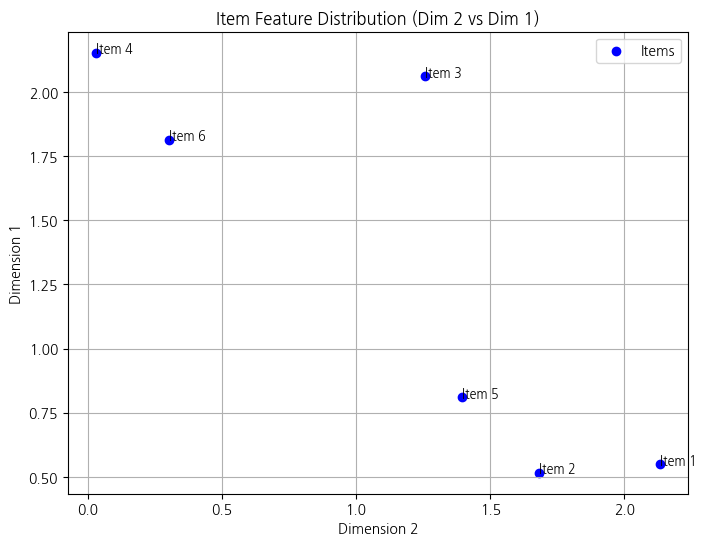

In [9]:
# Example Execution: Matrix Factorization
ratings_example = np.array([
    [5, 4, 0, 1, 0, 0],
    [4, 0, 0, 2, 3, 0],
    [1, 1, 0, 5, 0, 4],
    [0, 0, 5, 4, 0, 0],
])
user_names_example=["User 1", "User 2", "User 3", "User 4"]
item_names_example=["Item 1", "Item 2", "Item 3", "Item 4", "Item 5", "Item 6"]

display_ratings_with_placeholders(ratings_example, user_names_example, item_names_example)
print()

# Matrix factorization function
matrix_recommendations = matrix_factorization(
    ratings=ratings_example,
    dimension=2,
    epoch=1000,
    learning_rate=0.01,
    lambda_reg=0.1,
    top_n=2,
    user_names=user_names_example,
    item_names=item_names_example
)

,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드
Amy,4.00,4.00,?,?,?,?,4.00,?,3.00,?,...,?,3.00,?,?,3.00,?,?,?,1.00,4.00
Ethan,5.00,?,?,?,5.00,4.00,4.00,5.00,?,5.00,...,?,1.00,?,?,1.00,?,3.00,?,4.00,?
고얭이,?,?,?,4.00,?,?,?,5.00,?,5.00,...,?,?,5.00,?,?,?,?,?,?,?
ROY,1.00,?,1.00,?,3.00,4.00,4.00,1.00,3.00,4.00,...,1.00,1.00,1.00,1.00,1.00,?,1.00,?,1.00,1.00
어,4.00,4.00,?,?,?,?,?,5.00,5.00,?,...,?,4.00,?,?,3.00,?,?,?,5.00,?
ben,4.00,4.00,?,?,4.00,?,4.00,5.00,5.00,5.00,...,?,4.00,?,?,3.00,?,?,?,5.00,?
roxie,5.00,?,5.00,?,?,?,5.00,3.00,5.00,?,...,1.00,4.00,5.00,?,?,?,?,?,3.00,?
Leo,4.00,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
jack,?,?,?,?,?,?,5.00,?,?,?,...,?,?,?,?,?,?,?,?,?,?
hanskim,5.00,5.00,4.00,?,4.00,?,?,?,?,5.00,...,?,?,?,?,4.00,?,?,?,3.00,?



Iteration 100/1000, Loss: 0.0877
Iteration 200/1000, Loss: 0.0654
Iteration 300/1000, Loss: 0.0626
Iteration 400/1000, Loss: 0.0617
Iteration 500/1000, Loss: 0.0611
Iteration 600/1000, Loss: 0.0605
Iteration 700/1000, Loss: 0.0599
Iteration 800/1000, Loss: 0.0593
Iteration 900/1000, Loss: 0.0588
Iteration 1000/1000, Loss: 0.0583


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,3.95,3.92,3.41,3.48,3.86,3.07,3.89,2.93,3.09,3.54,...,0.81,2.71,3.91,1.34,2.88,2.58,2.26,2.59,1.31,3.84,"1917 (4.05), 미션 임파서블: 데드 레코닝 파트 원 (3.91), 어벤져스 (3.86)"
Ethan,4.44,3.39,2.97,3.20,4.46,3.96,3.97,4.53,3.82,4.86,...,0.88,1.39,3.74,1.35,1.45,3.09,2.94,3.30,3.68,3.71,"컨택트 (4.29), 탑건: 매버릭 (4.17), 놉 (4.14)"
고얭이,4.86,3.89,3.80,3.93,3.75,3.46,3.71,4.86,4.20,4.81,...,0.70,3.04,4.79,1.33,2.75,3.84,2.59,3.04,4.16,4.39,"인셉션 (4.86), 1917 (4.60), 탑건: 매버릭 (4.59)"
ROY,1.33,1.91,1.18,1.69,3.04,3.70,3.40,1.22,2.81,3.44,...,0.94,1.08,1.13,0.96,1.00,1.24,0.99,1.37,1.00,1.08,"놉 (2.02), 소셜 네트워크 (1.91), 탑건: 매버릭 (1.87)"
어,4.16,3.97,3.34,3.89,3.96,3.76,3.66,4.86,4.78,4.76,...,0.79,3.72,4.32,1.40,3.11,3.66,2.13,1.93,4.64,4.05,"매드 맥스: 분노의 도로 (4.76), 미션 임파서블: 데드 레코닝 파트 원 (4.32), 라라랜드 (4.22)"
ben,4.13,3.98,3.37,3.86,3.89,4.02,3.83,4.74,4.90,4.80,...,0.83,3.78,4.28,1.40,3.14,3.67,2.27,2.15,4.56,3.87,"미션 임파서블: 데드 레코닝 파트 원 (4.28), 1917 (4.10), 장고: 분노의 추적자 (4.02)"
roxie,4.68,4.10,4.59,4.32,4.66,4.03,4.80,3.46,4.81,5.09,...,0.98,3.88,4.84,1.37,3.18,3.40,1.64,2.77,2.96,4.16,"매드 맥스: 분노의 도로 (5.09), 컨택트 (5.02), 어벤져스 (4.66)"
Leo,3.93,3.73,3.17,3.41,3.40,3.21,3.34,3.59,3.51,3.53,...,0.69,2.92,3.84,1.24,2.96,2.73,2.28,2.21,2.51,3.65,"1917 (3.91), 컨택트 (3.87), 미션 임파서블: 데드 레코닝 파트 원 (3.84)"
jack,4.64,4.22,3.78,3.94,4.80,4.73,4.85,4.48,4.96,5.34,...,1.05,3.10,4.44,1.57,2.67,3.63,2.93,3.29,3.89,4.00,"매드 맥스: 분노의 도로 (5.34), 위플래쉬 (4.96), 컨택트 (4.88)"
hanskim,5.05,4.99,3.94,4.33,4.17,4.51,4.59,4.72,4.47,4.70,...,0.94,3.67,4.94,1.71,3.85,3.77,3.58,3.47,3.08,4.62,"컨택트 (5.23), 놉 (5.08), 1917 (5.06)"


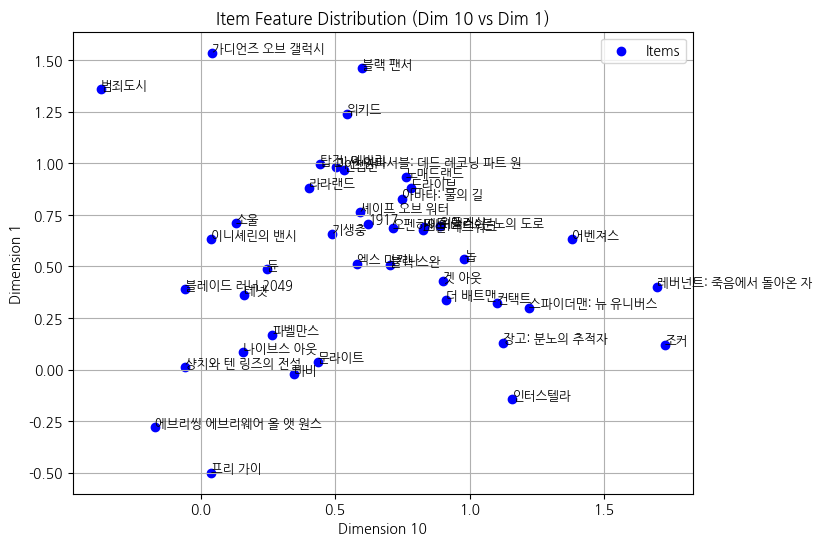

In [10]:
# Run matrix factorization

display_ratings_with_placeholders(rating_matrix, user_names, item_names)
print()

matrix_real_recommendations = matrix_factorization(
    ratings=rating_matrix,
    dimension=10,
    epoch=1000,
    learning_rate=0.01,
    lambda_reg=0.1,
    top_n=3,
    user_names=user_names,
    item_names=item_names
)

# GNN Recommendation

In [11]:
#@title GNN Code
def gnn_recommendation(ratings, hidden_dim=4, output_dim=2, epoch=1000, learning_rate=0.01,
                       top_n=3, plot_dimensions=True, display_iteration=True, display_html=True,
                       feature_dim=4, num_layers=2, user_names=None, item_names=None):
    num_users, num_items = ratings.shape

    # user_names와 item_names 기본값 설정
    if user_names is None:
        user_names = [f"User {i+1}" for i in range(num_users)]
    if item_names is None:
        item_names = [f"Item {j+1}" for j in range(num_items)]

    edge_index = []
    edge_weight = []
    x = []

    # 사용자 및 아이템 초기 특징 설정 (랜덤 초기화)
    for u in range(num_users):
        x.append(np.random.rand(feature_dim))
    for i in range(num_items):
        x.append(np.random.rand(feature_dim))

    for u in range(num_users):
        for i in range(num_items):
            if ratings[u, i] > 0:
                edge_index.append([u, num_users + i])
                edge_weight.append(ratings[u, i])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)
    x = torch.tensor(x, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

    class GCNRecommendation(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
            super(GCNRecommendation, self).__init__()
            self.convs = nn.ModuleList()
            if num_layers >= 1:
                self.convs.append(GCNConv(input_dim, hidden_dim))
            for _ in range(num_layers - 2):
                self.convs.append(GCNConv(hidden_dim, hidden_dim))
            if num_layers >= 2:
                self.convs.append(GCNConv(hidden_dim, output_dim))
            elif num_layers == 1:
                self.convs[0] = GCNConv(input_dim, output_dim)

        def forward(self, data):
            x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
            for conv in self.convs[:-1]:
                x = conv(x, edge_index, edge_weight)
                x = F.relu(x)
            if len(self.convs) > 0:
                x = self.convs[-1](x, edge_index, edge_weight)
            return x

    input_dim = feature_dim
    model = GCNRecommendation(input_dim, hidden_dim, output_dim, num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    normalized_ratings = torch.tensor(ratings / 5.0, dtype=torch.float)
    mask = (ratings > 0)

    interval = max(epoch // 10, 1)
    for epoch_idx in range(epoch):
        model.train()
        optimizer.zero_grad()
        predictions = model(data)

        user_embeds = predictions[:num_users]
        item_embeds = predictions[num_users:]
        pred_ratings = torch.matmul(user_embeds, item_embeds.t())

        loss = loss_fn(pred_ratings[mask], normalized_ratings[mask])
        loss.backward()
        optimizer.step()

        if display_iteration:
            if (epoch_idx + 1) % interval == 0 or epoch_idx == epoch - 1:
                print(f"Iteration {epoch_idx + 1}/{epoch}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        predictions = model(data)
        user_embeds = predictions[:num_users]
        item_embeds = predictions[num_users:]
        pred_ratings = torch.matmul(user_embeds, item_embeds.t())

    def recommend_items(predictions, ratings, user_indices, item_indices, top_n):
        recommendations = {}
        # 모든 사용자-아이템 쌍에 대한 예측 점수를 계산하고 역정규화
        scores_matrix = torch.matmul(predictions[user_indices], predictions[item_indices].T) * 5.0
        scores_matrix = scores_matrix.cpu().numpy()  # NumPy 배열로 변환

        for u_idx, user_idx in enumerate(user_indices):
            user_scores = scores_matrix[u_idx]  # 해당 사용자에 대한 모든 아이템 점수
            unseen_item_scores = []

            # 각 아이템에 대해
            for j, item_index in enumerate(item_indices):
                actual_item = item_index - num_users  # 실제 아이템 인덱스 계산
                # 해당 아이템을 사용자가 아직 보지 않았다면
                if ratings[user_idx, actual_item] == 0:
                    unseen_item_scores.append((item_names[actual_item], user_scores[j]))

            # 보지 않은 아이템들을 점수 기준 내림차순으로 정렬하고 top_n개 선택
            top_recs = sorted(unseen_item_scores, key=lambda x: x[1], reverse=True)[:top_n]
            recommendations[user_names[user_idx]] = top_recs

        return recommendations


    user_indices = list(range(num_users))
    item_indices = list(range(num_users, num_users + num_items))
    recommendations = recommend_items(predictions, ratings, user_indices, item_indices, top_n)

    # 플롯 부분 (이전과 동일)
    if plot_dimensions and output_dim >= 2:
        variances = predictions.var(dim=0).numpy()
        sorted_dims = np.argsort(-variances)
        x_dim, y_dim = sorted_dims[:2]

        # 유저 임베딩 시각화
        plt.figure(figsize=(8, 6))
        plt.scatter(predictions[:num_users, x_dim].cpu().numpy(),
                    predictions[:num_users, y_dim].cpu().numpy(),
                    color='red', label='Users')
        for u in range(num_users):
            plt.text(predictions[u, x_dim].item(),
                     predictions[u, y_dim].item(),
                     user_names[u], fontsize=9)
        plt.title(f"User Embeddings (Dim {x_dim+1} vs Dim {y_dim+1})")
        plt.xlabel(f"Dimension {x_dim+1}")
        plt.ylabel(f"Dimension {y_dim+1}")
        plt.grid(True)
        plt.legend()
        plt.show()

        # 아이템 임베딩 시각화
        plt.figure(figsize=(8, 6))
        plt.scatter(predictions[num_users:, x_dim].cpu().numpy(),
                    predictions[num_users:, y_dim].cpu().numpy(),
                    color='blue', label='Items')
        for i in range(num_items):
            plt.text(predictions[num_users + i, x_dim].item(),
                     predictions[num_users + i, y_dim].item(),
                     item_names[i], fontsize=9)
        plt.title(f"Item Embeddings (Dim {x_dim+1} vs Dim {y_dim+1})")
        plt.xlabel(f"Dimension {x_dim+1}")
        plt.ylabel(f"Dimension {y_dim+1}")
        plt.grid(True)
        plt.legend()
        plt.show()

    # 예측 평점 역정규화 및 DataFrame 생성
    denormalized_predictions = pred_ratings.cpu().numpy() * 5.0
    predicted_df = pd.DataFrame(
        denormalized_predictions,
        index=user_names,
        columns=item_names
    )

    if display_html:
        generate_html_table(predicted_df, "Graph Neural Network Recommendations", recommendations)

    summary = [predicted_df, recommendations]
    return summary


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,5.00,4.00,?,1.00,?,?
User 2,4.00,?,?,2.00,3.00,?
User 3,1.00,1.00,?,5.00,?,4.00
User 4,?,?,5.00,4.00,?,?


<ipython-input-11-66da7032f321>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.tensor(x, dtype=torch.float)


Iteration 100/1000, Loss: 0.0839
Iteration 200/1000, Loss: 0.0819
Iteration 300/1000, Loss: 0.0807
Iteration 400/1000, Loss: 0.0791
Iteration 500/1000, Loss: 0.0768
Iteration 600/1000, Loss: 0.0744
Iteration 700/1000, Loss: 0.0728
Iteration 800/1000, Loss: 0.0721
Iteration 900/1000, Loss: 0.0716
Iteration 1000/1000, Loss: 0.0621


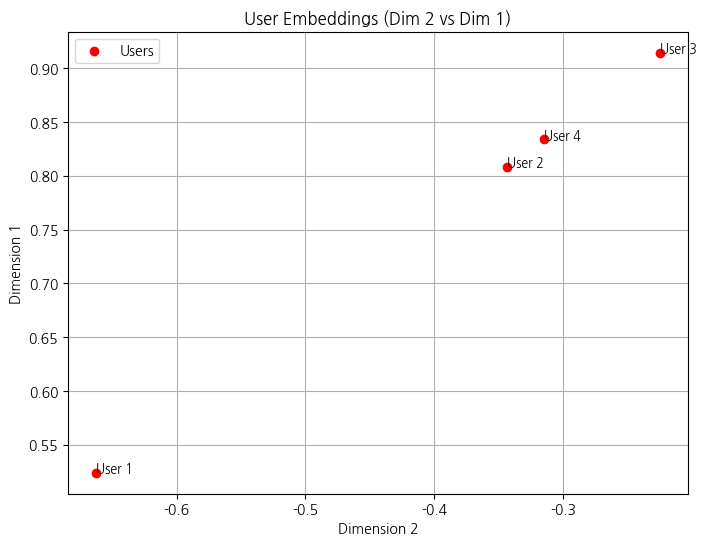

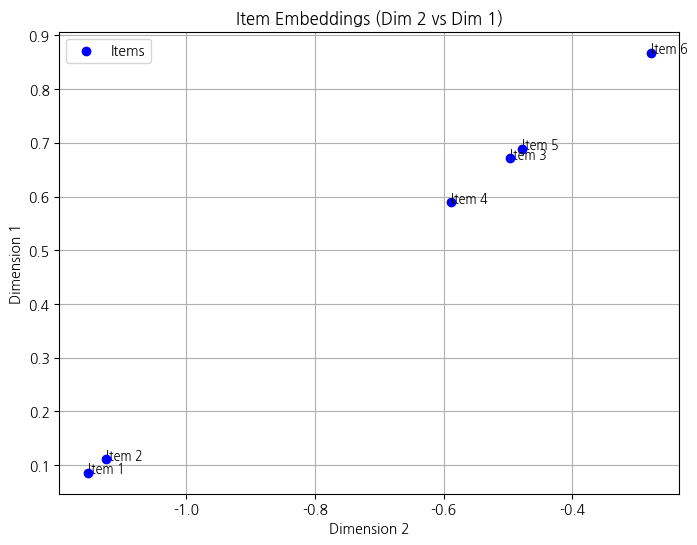

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Recommendations
User 1,4.04,4.02,3.41,3.50,3.39,3.19,"Item 3 (3.41), Item 5 (3.39), Item 6 (3.19)"
User 2,2.33,2.38,3.57,3.40,3.61,3.98,"Item 6 (3.98), Item 3 (3.57), Item 2 (2.38)"
User 3,1.69,1.77,3.63,3.36,3.69,4.28,"Item 5 (3.69), Item 3 (3.63)"
User 4,2.18,2.24,3.58,3.39,3.63,4.06,"Item 6 (4.06), Item 5 (3.63), Item 2 (2.24)"


In [12]:
# Example Execution
ratings_example = np.array([
    [5, 4, 0, 1, 0, 0],
    [4, 0, 0, 2, 3, 0],
    [1, 1, 0, 5, 0, 4],
    [0, 0, 5, 4, 0, 0],
])

user_names_example=["User 1", "User 2", "User 3", "User 4"]
item_names_example=["Item 1", "Item 2", "Item 3", "Item 4", "Item 5", "Item 6"]

display_ratings_with_placeholders(ratings_example, user_names_example, item_names_example)
print()

predictions, recommendations = gnn_recommendation(ratings_example)


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드
Amy,4.00,4.00,?,?,?,?,4.00,?,3.00,?,...,?,3.00,?,?,3.00,?,?,?,1.00,4.00
Ethan,5.00,?,?,?,5.00,4.00,4.00,5.00,?,5.00,...,?,1.00,?,?,1.00,?,3.00,?,4.00,?
고얭이,?,?,?,4.00,?,?,?,5.00,?,5.00,...,?,?,5.00,?,?,?,?,?,?,?
ROY,1.00,?,1.00,?,3.00,4.00,4.00,1.00,3.00,4.00,...,1.00,1.00,1.00,1.00,1.00,?,1.00,?,1.00,1.00
어,4.00,4.00,?,?,?,?,?,5.00,5.00,?,...,?,4.00,?,?,3.00,?,?,?,5.00,?
ben,4.00,4.00,?,?,4.00,?,4.00,5.00,5.00,5.00,...,?,4.00,?,?,3.00,?,?,?,5.00,?
roxie,5.00,?,5.00,?,?,?,5.00,3.00,5.00,?,...,1.00,4.00,5.00,?,?,?,?,?,3.00,?
Leo,4.00,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
jack,?,?,?,?,?,?,5.00,?,?,?,...,?,?,?,?,?,?,?,?,?,?
hanskim,5.00,5.00,4.00,?,4.00,?,?,?,?,5.00,...,?,?,?,?,4.00,?,?,?,3.00,?



Iteration 100/1000, Loss: 0.0378
Iteration 200/1000, Loss: 0.0280
Iteration 300/1000, Loss: 0.0235
Iteration 400/1000, Loss: 0.0221
Iteration 500/1000, Loss: 0.0214
Iteration 600/1000, Loss: 0.0219
Iteration 700/1000, Loss: 0.0203
Iteration 800/1000, Loss: 0.0200
Iteration 900/1000, Loss: 0.0196
Iteration 1000/1000, Loss: 0.0192


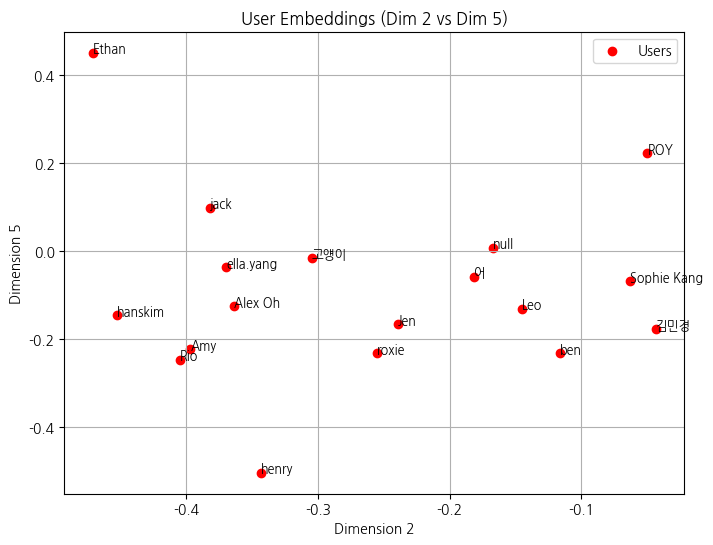

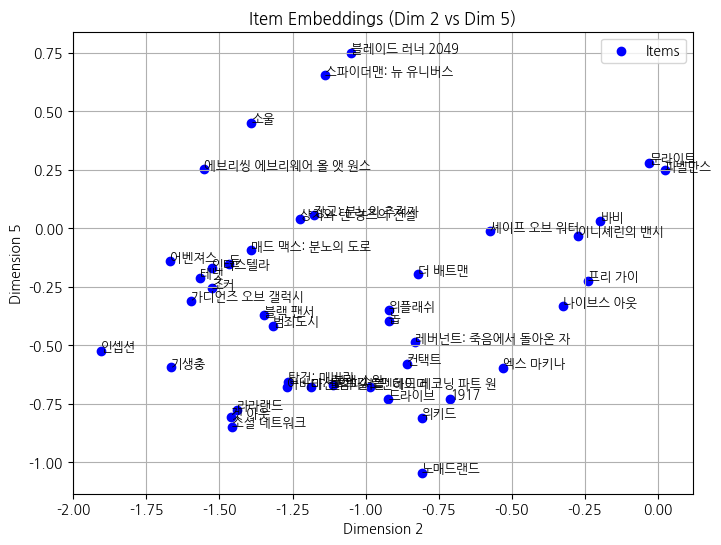

,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드,Recommendations
Amy,4.12,4.14,2.38,1.28,2.64,2.03,3.77,2.03,2.93,1.28,...,0.80,3.01,1.79,0.58,3.14,0.50,1.86,0.95,2.02,3.28,"어벤져스 (2.64), 블랙 스완 (2.38), 장고: 분노의 추적자 (2.03)"
Ethan,4.26,2.01,1.87,0.68,4.72,3.81,4.12,4.18,2.31,4.21,...,0.95,1.39,1.95,0.89,2.14,0.71,3.92,0.50,3.21,0.21,"듄 (3.04), 더 배트맨 (2.78), 위플래쉬 (2.31)"
고얭이,5.68,3.74,3.93,3.88,4.38,0.78,5.08,5.55,3.99,4.83,...,0.94,4.45,4.76,-0.05,3.43,0.89,1.24,2.82,5.12,1.33,"탑건: 매버릭 (6.32), 인셉션 (5.68), 범죄도시 (5.12)"
ROY,2.09,0.89,1.10,-0.75,2.37,3.41,3.56,1.94,2.87,2.26,...,1.65,1.77,0.54,2.38,1.61,0.17,2.56,1.43,1.83,1.46,"프리 가이 (1.43), 탑건: 매버릭 (1.02), 놉 (0.90)"
어,5.00,3.46,3.51,2.16,3.64,1.05,4.74,4.42,4.59,3.19,...,1.47,4.18,3.61,0.81,2.83,0.55,1.49,2.80,4.03,0.88,"인터스텔라 (4.74), 어벤져스 (3.64), 미션 임파서블: 데드 레코닝 파트 원 (3.61)"
ben,4.87,3.64,3.94,3.13,3.89,1.30,4.44,4.51,4.05,4.40,...,1.22,4.34,4.11,0.58,3.81,0.92,1.32,2.85,4.82,2.50,"1917 (4.12), 미션 임파서블: 데드 레코닝 파트 원 (4.11), 블랙 스완 (3.94)"
roxie,5.39,4.18,4.01,3.05,4.04,1.67,4.48,4.84,4.15,3.61,...,1.12,4.23,4.27,0.22,3.54,0.59,2.07,2.34,4.36,1.77,"기생충 (4.62), 소셜 네트워크 (4.18), 어벤져스 (4.04)"
Leo,3.91,2.91,2.85,2.25,2.66,1.63,4.15,3.69,3.65,2.59,...,1.17,3.76,3.19,0.78,2.60,0.13,1.47,2.30,3.15,1.81,"인터스텔라 (4.15), 탑건: 매버릭 (3.92), 컨택트 (3.87)"
jack,4.85,3.26,2.77,2.59,3.53,1.19,4.74,4.25,3.39,3.33,...,0.86,3.56,3.32,0.25,2.64,0.55,1.44,2.00,3.58,1.23,"인셉션 (4.85), 가디언즈 오브 갤럭시 (4.25), 소울 (4.13)"
hanskim,5.18,4.57,3.47,1.44,5.18,0.44,2.24,2.46,1.99,4.06,...,0.30,1.69,2.05,-0.58,4.14,2.54,1.56,0.42,4.22,2.08,"겟 아웃 (4.52), 셰이프 오브 워터 (4.43), 스파이더맨: 뉴 유니버스 (4.20)"


In [13]:
display_ratings_with_placeholders(rating_matrix, user_names, item_names)
print()

gnn_real_recommendations = gnn_recommendation(
    ratings=rating_matrix,
    feature_dim=8,
    hidden_dim=10,
    output_dim=8,
    num_layers=3,
    epoch=1000,
    learning_rate=0.01,
    top_n=3,
    user_names=user_names,
    item_names=item_names
)

# 종합 결과

In [14]:

# Hybrid 추천 결과 반환
hybrid_prediction_result_df, hybrid_recommendations_result = hybrid_recommendations(
    ratings=rating_matrix,
    item_features=transform_binary_to_signed(item_features),
    alpha=0.5,
    top_n=3,
    user_names=user_names,
    item_names=item_names,
    display_html=False,
    similarity_method="jaccard"
)

# Matrix Factorization 추천 결과 반환
matrix_predicttion_result_df, matrix_recommendations_result = matrix_factorization(
    ratings=rating_matrix,
    dimension=10,
    epoch=1000,
    learning_rate=0.01,
    lambda_reg=0.1,
    top_n=3,
    user_names=user_names,
    item_names=item_names,
    plot_dimensions=False,
    display_iteration=False,
    display_html=False
)

gnn_predicttion_result_df, gnn_recommendations_result = gnn_recommendation(
    ratings=rating_matrix,
    feature_dim=8,
    hidden_dim=10,
    output_dim=8,
    num_layers=3,
    epoch=1000,
    learning_rate=0.01,
    top_n=3,
    user_names=user_names,
    item_names=item_names,
    plot_dimensions=False,
    display_iteration=False,
    display_html=False
)


# 결과를 HTML 테이블로 표시
generate_html_table(hybrid_prediction_result_df, "Hybrid Predictions")
generate_html_table(matrix_predicttion_result_df, "Matrix Factorization Predictions")
generate_html_table(gnn_predicttion_result_df, "Graph Neural Network Predictions")

# 종합 결과를 하나의 표로 출력
generate_summary_table(
    [hybrid_recommendations_result, matrix_recommendations_result, gnn_recommendations_result],
    ["Hybrid Recommendations", "Matrix Factorization Recommendations", "Graph Neural Network Predictions"],
    user_names)

,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드
Amy,2.51,1.84,1.04,0.71,0.66,0.64,2.08,0.51,1.37,0.80,...,-0.35,1.52,0.84,0.59,1.30,0.47,-0.06,0.20,1.14,0.71
Ethan,2.94,1.02,0.19,0.62,2.07,1.39,2.21,2.21,0.74,2.18,...,-0.18,0.86,1.14,0.33,1.61,0.18,1.13,0.74,1.89,0.02
고얭이,1.20,0.75,0.37,1.32,0.78,0.55,0.83,2.22,0.51,2.26,...,0.05,0.51,1.99,0.11,0.86,0.13,0.52,0.23,1.00,0.26
ROY,-0.52,-0.31,-0.12,0.42,-0.41,0.76,0.48,-0.71,0.42,0.20,...,-0.14,0.17,0.36,0.71,-0.14,0.35,-0.16,-0.02,-0.13,-0.40
어,2.51,1.90,0.97,0.97,0.77,0.85,1.58,1.52,1.96,1.23,...,-0.44,1.86,1.09,0.62,1.55,0.48,0.15,0.03,2.54,0.05
ben,2.67,1.92,0.90,1.14,1.29,1.05,2.15,1.70,1.76,1.77,...,-0.49,1.72,1.40,0.74,1.90,0.50,0.41,0.30,2.46,-0.04
roxie,2.69,1.45,1.73,1.10,0.73,0.75,2.14,1.11,1.93,1.11,...,-0.37,1.98,1.94,0.61,1.15,0.35,0.25,0.04,2.15,-0.04
Leo,2.27,0.41,0.35,0.10,0.64,0.17,0.56,0.56,0.39,0.38,...,-0.07,0.43,0.29,-0.01,0.37,-0.03,0.19,0.15,0.74,0.05
jack,1.08,0.72,0.51,0.21,0.84,0.35,2.61,0.70,0.62,0.74,...,-0.07,0.65,0.46,0.21,0.95,0.10,0.29,0.28,0.79,0.08
hanskim,2.57,1.85,1.00,0.86,1.42,0.95,1.77,1.32,1.09,1.77,...,-0.29,1.13,1.15,0.53,1.84,0.40,0.51,0.39,1.92,0.22


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드
Amy,3.96,3.90,3.43,3.45,3.72,2.95,3.92,2.87,3.10,3.66,...,0.79,2.72,3.91,1.22,2.90,3.43,2.22,2.89,1.32,3.84
Ethan,4.44,3.44,2.80,3.29,4.48,3.96,3.98,4.57,3.74,4.87,...,1.00,1.38,3.71,1.22,1.41,3.67,2.94,3.50,3.65,3.59
고얭이,4.95,4.00,3.83,3.93,3.85,3.48,3.88,4.83,4.36,4.81,...,0.81,3.10,4.80,1.38,2.71,3.78,2.74,3.44,4.26,4.41
ROY,1.35,1.93,1.19,1.67,2.99,3.69,3.42,1.20,2.81,3.44,...,0.94,1.08,1.12,0.96,1.02,1.47,0.99,1.06,1.03,1.08
어,4.16,3.95,3.28,3.95,3.76,3.75,3.66,4.84,4.79,4.86,...,0.84,3.72,4.32,1.38,3.12,3.41,2.02,2.01,4.66,4.08
ben,4.11,3.98,3.27,3.92,3.83,4.01,3.84,4.77,4.90,4.85,...,0.87,3.79,4.26,1.37,3.12,3.22,2.15,2.04,4.54,3.89
roxie,4.69,4.09,4.57,4.20,4.00,3.91,4.75,3.41,4.80,5.36,...,0.98,3.90,4.84,1.63,3.46,3.42,1.57,2.98,3.00,4.39
Leo,3.93,3.64,3.19,3.43,3.40,3.26,3.49,3.62,3.69,3.93,...,0.74,2.90,3.87,1.18,2.82,3.03,2.15,2.42,2.78,3.67
jack,4.63,4.15,3.72,3.97,4.51,4.64,4.85,4.44,4.97,5.59,...,1.12,3.11,4.44,1.61,2.69,3.72,2.70,3.34,3.99,4.04
hanskim,5.04,5.02,4.02,4.28,4.15,4.46,4.70,4.47,4.63,4.65,...,0.96,3.71,4.92,1.56,3.84,4.02,3.69,3.64,3.10,4.58


,인셉션,소셜 네트워크,블랙 스완,드라이브,어벤져스,장고: 분노의 추적자,인터스텔라,가디언즈 오브 갤럭시,위플래쉬,매드 맥스: 분노의 도로,...,바비,오펜하이머,미션 임파서블: 데드 레코닝 파트 원,파벨만스,아바타: 물의 길,이니셰린의 밴시,샹치와 텐 링즈의 전설,프리 가이,범죄도시,위키드
Amy,5.18,3.39,3.25,1.70,3.99,2.86,4.25,3.36,2.29,3.51,...,0.94,2.95,2.06,0.80,3.27,0.77,2.87,2.82,3.88,2.48
Ethan,5.62,3.69,3.53,2.05,4.35,3.09,4.50,3.68,2.46,3.87,...,1.02,3.29,2.32,0.88,3.60,0.78,2.96,3.08,4.27,2.80
고얭이,4.84,3.94,3.60,4.36,4.16,2.80,3.96,4.74,3.24,4.61,...,1.41,4.12,4.33,1.01,4.23,1.27,2.19,2.15,4.48,3.96
ROY,2.96,2.39,2.16,1.96,2.47,1.63,2.56,2.81,2.24,2.49,...,0.94,2.38,2.36,0.66,2.38,0.94,1.59,1.27,2.60,1.86
어,4.87,4.02,3.63,3.90,4.15,2.66,4.06,4.87,3.77,4.35,...,1.59,4.21,4.32,1.09,4.12,1.52,2.31,2.01,4.47,3.43
ben,4.10,4.01,3.29,2.69,3.64,2.09,4.43,4.98,4.77,3.73,...,1.75,3.81,4.31,1.04,3.74,2.18,2.82,1.09,3.83,2.26
roxie,4.64,4.09,3.63,3.21,4.01,2.53,4.48,5.11,4.51,4.04,...,1.81,4.10,4.47,1.12,3.97,2.06,2.85,1.56,4.26,2.83
Leo,4.44,3.36,3.10,2.97,3.65,2.43,3.54,3.82,2.76,3.67,...,1.18,3.39,3.14,0.89,3.43,1.02,2.08,2.10,3.83,2.89
jack,5.38,4.20,3.61,1.71,4.35,2.76,5.18,4.44,3.87,3.92,...,1.34,3.53,3.01,0.96,3.82,1.53,3.48,2.37,4.23,2.25
hanskim,5.57,3.71,3.54,2.24,4.34,3.06,4.44,3.76,2.53,3.93,...,1.05,3.37,2.47,0.90,3.65,0.81,2.88,3.01,4.30,2.89


,Hybrid Recommendations,Matrix Factorization Recommendations,Graph Neural Network Predictions
Amy,"블랙 스완 (1.04), 1917 (1.01), 블레이드 러너 2049 (0.97)","1917 (4.17), 미션 임파서블: 데드 레코닝 파트 원 (3.91), 소울 (...","어벤져스 (3.99), 소울 (3.88), 매드 맥스: 분노의 도로 (3.51)"
Ethan,"탑건: 매버릭 (1.49), 듄 (1.29), 미션 임파서블: 데드 레코닝 파트 원...","컨택트 (4.26), 놉 (3.96), 탑건: 매버릭 (3.92)","탑건: 매버릭 (4.48), 듄 (4.16), 소셜 네트워크 (3.69)"
고얭이,"인셉션 (1.20), 기생충 (1.02), 범죄도시 (1.00)","인셉션 (4.95), 탑건: 매버릭 (4.70), 1917 (4.69)","인셉션 (4.84), 탑건: 매버릭 (4.73), 범죄도시 (4.48)"
ROY,"드라이브 (0.42), 노매드랜드 (0.37), 이니셰린의 밴시 (0.35)","놉 (2.01), 노매드랜드 (2.00), 소셜 네트워크 (1.93)","탑건: 매버릭 (2.79), 소셜 네트워크 (2.39), 드라이브 (1.96)"
어,"인터스텔라 (1.58), 라라랜드 (1.49), 테넷 (1.24)","매드 맥스: 분노의 도로 (4.86), 미션 임파서블: 데드 레코닝 파트 원 (4....","매드 맥스: 분노의 도로 (4.35), 미션 임파서블: 데드 레코닝 파트 원 (4...."
ben,"미션 임파서블: 데드 레코닝 파트 원 (1.40), 1917 (1.31), 듄 (1...","미션 임파서블: 데드 레코닝 파트 원 (4.26), 소울 (4.10), 장고: 분노...","미션 임파서블: 데드 레코닝 파트 원 (4.31), 블랙 스완 (3.29), 겟 아..."
roxie,"기생충 (1.60), 소셜 네트워크 (1.45), 컨택트 (1.45)","매드 맥스: 분노의 도로 (5.36), 컨택트 (5.05), 소울 (4.47)","라라랜드 (4.42), 블랙 팬서 (4.28), 기생충 (4.23)"
Leo,"기생충 (0.75), 범죄도시 (0.74), 어벤져스 (0.64)","매드 맥스: 분노의 도로 (3.93), 컨택트 (3.92), 1917 (3.89)","탑건: 매버릭 (4.03), 기생충 (3.85), 범죄도시 (3.83)"
jack,"인셉션 (1.08), 아바타: 물의 길 (0.95), 블랙 팬서 (0.91)","매드 맥스: 분노의 도로 (5.59), 위플래쉬 (4.97), 컨택트 (4.86)","인셉션 (5.38), 기생충 (4.64), 가디언즈 오브 갤럭시 (4.44)"
hanskim,"인터스텔라 (1.77), 블랙 팬서 (1.47), 가디언즈 오브 갤럭시 (1.32)","컨택트 (5.17), 1917 (5.09), 놉 (5.01)","인터스텔라 (4.44), 가디언즈 오브 갤럭시 (3.76), 컨택트 (3.67)"
